In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_pickle('train.pkl')

In [3]:
df=train.copy()

In [4]:
df.head()

,game_id,winner,time,player,species,event,event_contents
0,0,1,0,0,0,0,"at (145.25, 21.5078125)"
1,0,1,0,1,0,0,"at (22.75, 147.0078125)"
2,0,1,0,0,0,1,['OrbitalCommand [3080001]']
3,0,1,0,0,0,2,(1360) - TrainSCV
4,0,1,0,0,0,0,"at (142.99609375, 24.50390625)"


In [5]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64204077 entries, 0 to 64204076
Data columns (total 7 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   game_id         uint16
 1   winner          uint8 
 2   time            uint8 
 3   player          uint8 
 4   species         uint8 
 5   event           uint8 
 6   event_contents  object
dtypes: object(1), uint16(1), uint8(5)
memory usage: 918.4+ MB


In [6]:
df.describe()

,game_id,winner,time,player,species,event
count,6.420408e+07,6.420408e+07,6.420408e+07,6.420408e+07,6.420408e+07,6.420408e+07
mean,1.861381e+04,5.011006e-01,3.984620e+00,4.993334e-01,9.155748e-01,1.557664e+00
std,1.074859e+04,4.999988e-01,2.708632e+00,4.999996e-01,8.590866e-01,1.849485e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,9.294000e+03,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.863300e+04,1.000000e+00,4.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
75%,2.794300e+04,1.000000e+00,6.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00
max,3.721700e+04,1.000000e+00,1.000000e+01,1.000000e+00,2.000000e+00,7.000000e+00


In [7]:
df.isnull().sum()

game_id                  0
winner                   0
time                     0
player                   0
species                  0
event                    0
event_contents    10114089
dtype: int64

##### event_contents에만 결측값 확인.

In [8]:
null_rows = df[df.isnull().any(axis=1)]

df_null=pd.DataFrame(null_rows)
df_null['event'].unique()

array([4, 5, 6, 7], dtype=uint8)

'SetControlGroup': 4, 'GetControlGroup': 5, 'AddToControlGroup': 6, 'ControlGroup': 7 이므로 각 ControlGroup하는 행동들에 결측값이 보임.

# train.csv / test.csv

### game_id : 경기 구분 기호

### winner : player 1의 승리 확률

### time : 경기 시간, 마침표(.)로 분과 초가 구분됩니다. ex) 2.24 = 2분 24초﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿, ﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿﻿

+ player : 선수

### 1) 0: player 0

### 2) 1: player 1

+ species : 종족

### 1) T: 테란 :0

### 2) P: 프로토스 :1

### 3) Z: 저그:2

+ event : 행동 종류

+ event_contents : 행동 상세

### 1) Ability : 생산, 공격 등 선수의 주요 행동

### 2) AddToControlGroup : 부대에 추가

### 3) Camera : 시점 선택

### 4) ControlGroup : 부대 행동

### 5) GetControlGroup : 부대 불러오기

### 6) Right Click : 마우스 우클릭

### 7) Selection : 객체 선택

### 8) SetControlGroup : 부대 지정

### {'Camera': 0, 'Selection': 1, 'Ability': 2, 'Right Click': 3, 'SetControlGroup': 4, 'GetControlGroup': 5, 'AddToControlGroup': 6, 'ControlGroup': 7}

+ sample_submission.csv

### game_id : 경기 구분 기호

### winner : player 1의 승리 확률

In [7]:
position_data = df['event_contents'].str.extract(r'at \(([\d.]+),\s*([\d.]+)\)')
df['x_position'] = position_data[0].astype(float)
df['y_position'] = position_data[1].astype(float)

# 유닛 정보 추출
df['unit'] = df['event_contents'].str.extract(r'\[([^]]+)\]')

# 행동 정보 추출
action_data = df['event_contents'].str.extract(r'\((\d+)\) - (.+)')
df['action_name'] = action_data[1]

MemoryError: Unable to allocate 980. MiB for an array with shape (2, 64204077) and data type object

In [ ]:
df['action_type'] = df['action_name'].str.extract(pattern, expand=False)

# NaN 값을 빈 문자열로 대체
df['action_name'].fillna('', inplace=True)
df['action_type'].fillna('', inplace=True)

# 문자열 추출
def extract_unit_or_building(row):
    action_type = row['action_type']
    if action_type:
        return re.search(f'{action_type}([A-Za-z]+)', row['action_name']).group(1)
    else:
        return ''

df['extracted_action'] = df.apply(extract_unit_or_building, axis=1)

#attack 추출
def extract_location(event_content):
    match = re.search(r'Location: \(([\d.]+), ([\d.]+), (\d+)\)', event_content)
    if match:
        return match.groups()
    else:
        return (None, None, None)

# 'Attack' 열이 있는 경우에만 좌표 정보 추출
df['Location'] = df[df['event_contents'].str.contains('Attack', na=False)]['event_contents'].apply(extract_location)

df.head(10)

#  EDA
### 데이터 game_id별 정리 (전체적인 데이터 구조를 살펴보기위해..)

In [9]:
df['game_id'].unique()

array([    0,     1,     2, ..., 37215, 37216, 37217], dtype=uint16)

In [11]:
#시간 열 추가
df_train['time'] = np.array(train[train.shift(-1).game_id != train.game_id].time)

In [12]:
#종족열 추가
df_x = train[train.player==0]
df_train['player0_species']=np.array(df_x[df_x.shift(-1).game_id != df_x.game_id].species)
df_x = train[train.player==1]
df_train['player1_species']=np.array(df_x[df_x.shift(-1).game_id != df_x.game_id].species)

In [13]:
#이벤트 카운트 열
df_x = train[train.player==0]
df_train['event_count_0'] = np.array(df_x.game_id.value_counts()[df_x.game_id.unique()])
df_x = train[train.player==1]
df_train['event_count_1'] = np.array(df_x.game_id.value_counts()[df_x.game_id.unique()])

In [14]:
ev_co={0: 'Camera', 1: 'Selection', 2: 'Ability', 3: 'Right Click', 4: 'SetControlGroup', 5: 'GetControlGroup', 6: 'AddToControlGroup', 7: 'ControlGroup'}

In [15]:
for event in train.event.unique():
    df_x = train[(train.player==0)&(train.event==event)]
    df_x = pd.DataFrame(df_x.game_id.value_counts()[df_x.game_id.unique()]).rename({'game_id':ev_co[event]+'_count_0'}, axis = 1)
    df_x['game_id']= np.array(df_x.index)
    df_train = pd.merge(df_train, df_x, on='game_id', how='left')

    df_x = train[(train.player==1)&(train.event==event)]
    df_x = pd.DataFrame(df_x.game_id.value_counts()[df_x.game_id.unique()]).rename({'game_id':ev_co[event]+'_count_1'}, axis = 1)
    df_x['game_id']= np.array(df_x.index)
    df_train = pd.merge(df_train, df_x, on='game_id', how='left')
df_train = df_train.fillna(0)

In [16]:
for event in train.event.unique():
    df_train[ev_co[event] + '_diff'] = df_train[ev_co[event]+'_count_0'] - df_train[ev_co[event]+'_count_1']

In [17]:
df_train['event_diff']=df_train['event_count_0']-df_train['event_count_1']

In [18]:
#승자의 종족 추가
df_train['winner_species'] = df_train.apply(lambda row: row['player0_species'] if row['winner'] == 0 else row['player1_species'], axis=1)

In [52]:
df_train

,game_id,winner,time,player0_species,player1_species,event_count_0,event_count_1,Camera_count_0,Camera_count_1,Selection_count_0,...,Selection_diff,Ability_diff,Right Click_diff,SetControlGroup_diff,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff,event_diff,winner_species,adjusted_event_diff
0,0,1,7,0,0,592,548,444.0,425.0,50.0,...,-7.0,0.0,7.0,2.0,21.0,2.0,0.0,44,0.0,-44.0
1,1,1,9,1,0,1223,1211,627.0,858.0,186.0,...,70.0,10.0,29.0,2.0,131.0,1.0,0.0,12,0.0,-12.0
2,2,0,9,1,2,851,1371,413.0,725.0,90.0,...,-142.0,-16.0,-44.0,5.0,-10.0,1.0,-2.0,-520,1.0,-520.0
3,3,0,9,0,1,1389,1622,713.0,388.0,180.0,...,32.0,-7.0,8.0,-13.0,-578.0,0.0,0.0,-233,0.0,-233.0
4,4,0,5,0,2,966,651,430.0,272.0,67.0,...,-59.0,21.0,71.0,2.0,125.0,-3.0,0.0,315,0.0,315.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37213,37213,1,9,2,0,661,1226,344.0,731.0,167.0,...,51.0,-36.0,-132.0,-1.0,-57.0,-3.0,0.0,-565,0.0,565.0
37214,37214,1,9,0,0,1036,1439,593.0,647.0,119.0,...,-24.0,-21.0,-145.0,-9.0,-150.0,0.0,0.0,-403,0.0,403.0
37215,37215,1,2,0,0,258,291,64.0,244.0,39.0,...,30.0,5.0,16.0,0.0,94.0,2.0,0.0,-33,0.0,33.0
37216,37216,0,6,0,2,1289,566,527.0,280.0,111.0,...,-22.0,20.0,134.0,-2.0,341.0,5.0,0.0,723,0.0,723.0


## 1. 단일 변수
### 1) 승리여부

1    18670
0    18548
Name: winner, dtype: int64

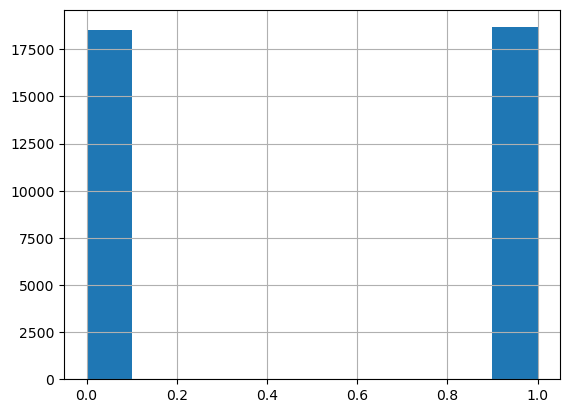

In [20]:
df_train.winner.hist()
df_train.winner.value_counts()

Player 1의 승리 수가 더 많음.

### 2) 시간별

In [20]:
df_train.time.unique()

array([ 7,  9,  5,  3,  6, 10,  4,  2,  8,  1,  0], dtype=uint8)

9     13198
8      3511
7      3470
6      3243
4      3134
5      3104
10     2785
3      2489
2      1287
1       612
0       385
Name: time, dtype: int64

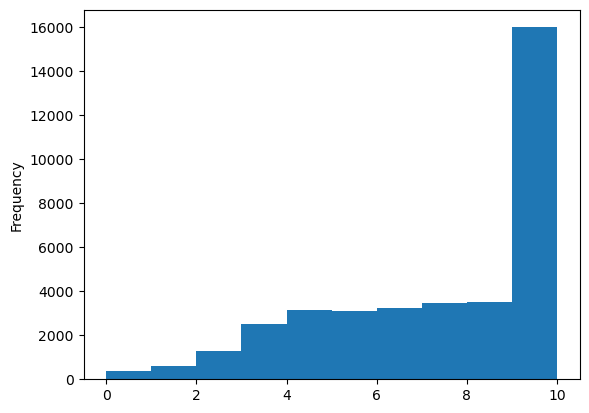

In [21]:
df_train.time.plot(kind='hist')
df_train.time.value_counts()

#### 9분대가 가장 많음. 
#### 초반(0분대~1분대)에 게임이 끝난 요인? =>의미있는 데이터일까?

In [22]:
#time이 0이나 1인 game_id
df_win01=df_train[(df_train['time'] == 0) | (df_train['time'] == 1)]
df_win01

,game_id,winner,time,player0_species,player1_species,event_count_0,event_count_1,Camera_count_0,Camera_count_1,Selection_count_0,...,Camera_diff,Selection_diff,Ability_diff,Right Click_diff,SetControlGroup_diff,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff,event_diff,winner_species
88,88,0,1,1,0,33,46,16.0,31.0,3.0,...,-15.0,-2.0,0.0,1.0,2.0,1.0,0.0,0.0,-13,1.0
143,143,1,1,2,1,229,141,72.0,83.0,27.0,...,-11.0,18.0,2.0,24.0,1.0,54.0,0.0,0.0,88,1.0
182,182,1,1,0,0,106,208,47.0,86.0,11.0,...,-39.0,-12.0,-4.0,-20.0,-4.0,-23.0,0.0,0.0,-102,0.0
187,187,0,0,2,2,70,30,22.0,0.0,25.0,...,22.0,13.0,0.0,-2.0,6.0,1.0,0.0,0.0,40,2.0
200,200,1,0,1,1,59,16,59.0,2.0,0.0,...,57.0,-2.0,-1.0,-1.0,-2.0,-8.0,0.0,0.0,43,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37097,37097,1,1,2,2,130,169,53.0,89.0,28.0,...,-36.0,-8.0,1.0,4.0,0.0,0.0,0.0,0.0,-39,2.0
37171,37171,1,1,2,1,76,61,6.0,25.0,22.0,...,-19.0,21.0,4.0,5.0,2.0,2.0,0.0,0.0,15,1.0
37193,37193,0,0,1,0,37,33,18.0,13.0,11.0,...,5.0,-2.0,-1.0,-3.0,0.0,5.0,0.0,0.0,4,1.0
37210,37210,1,0,0,2,16,127,6.0,20.0,2.0,...,-14.0,-50.0,0.0,-2.0,-2.0,-43.0,0.0,0.0,-111,2.0


In [35]:
#게임시간이 0이거나 1인 데이터
selected_rows = df[df['game_id'].isin(df_win01['game_id'].values)]
selected_rows

,game_id,winner,time,player,species,event,event_contents
138886,88,0,0,0,1,0,"at (36.75, 122.0078125)"
138887,88,0,0,0,1,1,"['Probe [3140001]', 'Probe [3180001]', 'Probe ..."
138888,88,0,0,0,1,3,"Location: (172.51904296875, 19.89599609375, 48..."
138889,88,0,0,1,0,1,['CommandCenter [3440001]']
138890,88,0,0,0,1,3,"Location: (167.877685546875, 19.89599609375, 4..."
...,...,...,...,...,...,...,...
64204072,37217,1,1,0,0,5,NaN
64204073,37217,1,1,0,0,5,NaN
64204074,37217,1,1,1,1,0,"at (100.25390625, 103.9921875)"
64204075,37217,1,1,0,0,5,NaN


In [81]:
#0- 1 분대 게임 중 특정 데이터 셋
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_shortgame=df[df['game_id'] == 143]
df_shortgame

,game_id,winner,time,player,species,event,event_contents
231241,143,1,0,1,1,0,"at (145.25, 21.5078125)"
231242,143,1,0,1,1,1,['Nexus [34C0001]']
231243,143,1,0,1,1,2,(15E0) - TrainProbe
231244,143,1,0,1,1,1,['Probe [3700001]']
231245,143,1,0,1,1,3,"Target: None [025C0001]; Location: (144.0, 18...."
231246,143,1,0,1,1,3,"Target: None [025C0001]; Location: (144.0, 18...."
231247,143,1,0,1,1,4,NaN
231248,143,1,0,1,1,3,"Target: None [016C0001]; Location: (150.0, 24...."
231249,143,1,0,1,1,3,"Target: None [016C0001]; Location: (150.0, 24...."
231250,143,1,0,1,1,0,"at (145.25, 24.2734375)"


In [ ]:
#먼저 극 초반에 attack 또는 다른 행동을 취한 팀이 이길까? => 나중에

### 3) 종족간 data

In [23]:
print(df_train['player0_species'].value_counts())
print(df_train['player1_species'].value_counts())

0    14415
2    12370
1    10433
Name: player0_species, dtype: int64
0    14613
2    12136
1    10469
Name: player1_species, dtype: int64


0    29028
2    24506
1    20902
dtype: int64


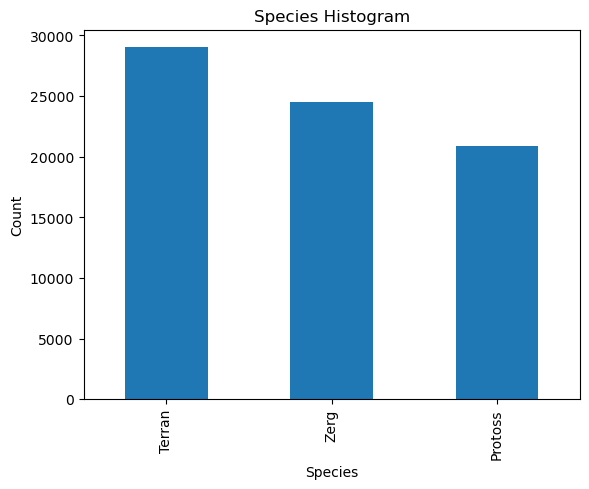

In [24]:
player0_species_count = df_train['player0_species'].value_counts()
player1_species_count = df_train['player1_species'].value_counts()

print(player0_species_count.add(player1_species_count, fill_value=0))
total_species_count = player0_species_count.add(player1_species_count, fill_value=0)
ax = total_species_count.plot(kind='bar', title='Species Histogram', xlabel='Species', ylabel='Count')

new_labels = ['Terran', 'Zerg', 'Protoss'] 
plt.xticks(range(len(new_labels)), new_labels)

plt.show()

테란이 가장 많음(테란-프로토스-저그 순)

### 종족간 승률

In [25]:
subset0 = df_train[((df_train['player0_species'] == 0) & (df_train['player1_species'] == 2)) |
                ((df_train['player0_species'] == 2) & (df_train['player1_species'] == 0))]

subset1 = df_train[((df_train['player0_species'] == 0) & (df_train['player1_species'] == 1)) |
                ((df_train['player0_species'] == 1) & (df_train['player1_species'] == 0))]

subset2 = df_train[((df_train['player0_species'] == 1) & (df_train['player1_species'] == 2)) |
                ((df_train['player0_species'] == 2) & (df_train['player1_species'] == 1))]

In [26]:
t_win=len(subset0[subset0['winner_species'] == 0])/ len(subset0)
t_win1=len(subset1[subset1['winner_species'] == 0])/ len(subset1)
p_win1=len(subset1[subset1['winner_species'] == 1])/ len(subset1)
p_win2=len(subset2[subset2['winner_species'] == 1])/ len(subset2)
z_win=len(subset0[subset0['winner_species'] == 2])/len(subset0)
z_win2=len(subset2[subset2['winner_species'] == 2])/len(subset2)

In [27]:
print('T vs Z 승률','T 승률',round(t_win,4),'Z 승률', round(z_win,4))
print('T vs P 승률','T 승률',round(t_win1,4),'P 승률', round(p_win1,4))
print('P vs Z 승률','P 승률',round(p_win2,4),'Z 승률', round(z_win2,4))

T vs Z 승률 T 승률 0.4937 Z 승률 0.5063
T vs P 승률 T 승률 0.5015 P 승률 0.4985
P vs Z 승률 P 승률 0.4887 Z 승률 0.5113


저그는 테란과 프로토스 둘다보다 승률이 높음.
테란은 프로토스전에서 승률이 근소 우위임.
프로토스는 둘다에게 승률이 낮음.

=>상성문제?

### 시간대별 승리 비교

    Terran_win  Protoss_win
0           39           37
1           49           71
2          107          111
3          235          244
4          333          348
5          414          351
6          507          327
7          497          343
8          384          379
9         1323         1589
10         282          345


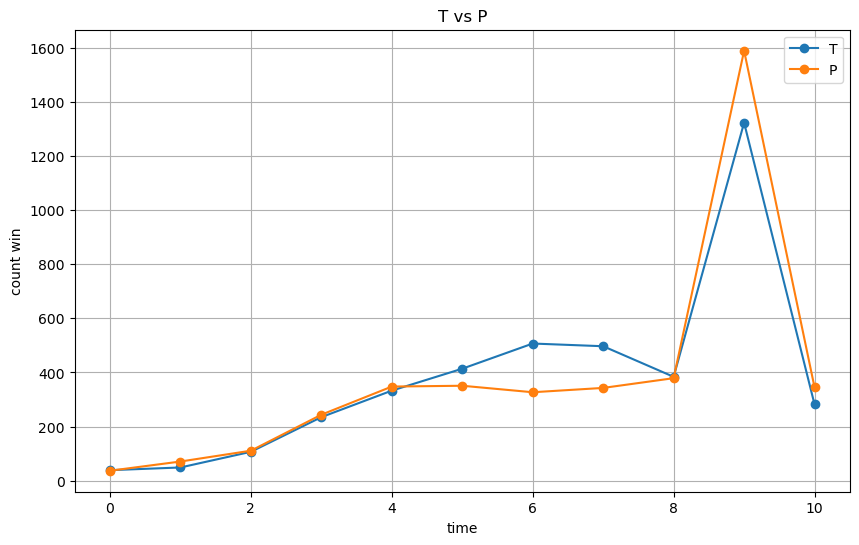

In [28]:
#T vs P

time_wins_species_TP = subset1[subset1['winner_species'] == 0].groupby('time')['winner_species'].count()
time_wins_species_PT = subset1[subset1['winner_species'] == 1].groupby('time')['winner_species'].count()

result_TP = pd.DataFrame({'Terran_win': time_wins_species_TP.values, 'Protoss_win': time_wins_species_PT.values})
print(result_TP)

plt.figure(figsize=(10, 6))
plt.plot(time_wins_species_TP.index, time_wins_species_TP.values, marker='o', linestyle='-', label='Winner Species 0')
plt.plot(time_wins_species_PT.index, time_wins_species_PT.values, marker='o', linestyle='-', label='Winner Species 1')
plt.xlabel('time')
plt.ylabel('count win')
plt.title('T vs P')
plt.legend(['T','P'])
plt.grid(True)

plt.show()

### 4분까지 둘이 비슷하고  4에서 8분까지는 테란이 더 유리하다. 8분 이후는 P가 쎔.

    Terran_win  Zerg_win
0           32        45
1           48        53
2          107       174
3          161       368
4          360       355
5          388       261
6          404       252
7          515       290
8          530       419
9         1945      2325
10         376       449


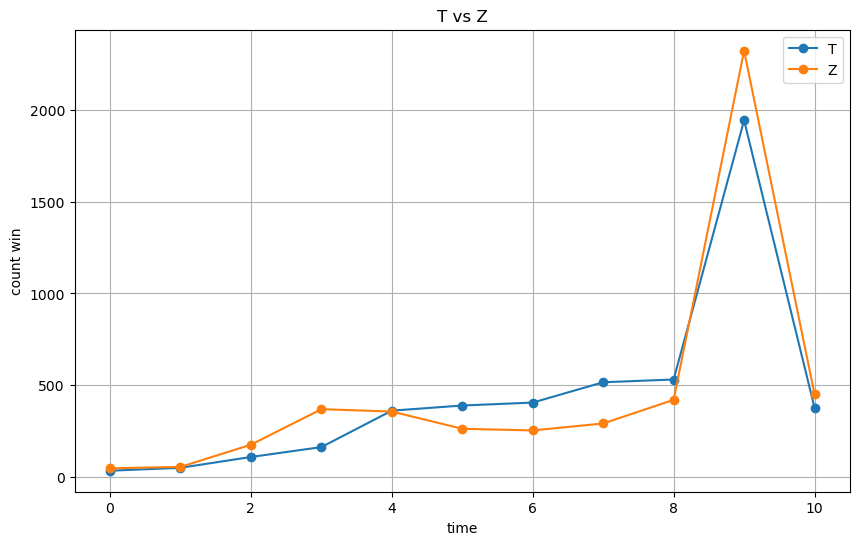

In [29]:
#T vs Z

time_wins_species_TZ = subset0[subset0['winner_species'] == 0].groupby('time')['winner_species'].count()
time_wins_species_ZT = subset0[subset0['winner_species'] == 2].groupby('time')['winner_species'].count()

result_TZ = pd.DataFrame({'Terran_win': time_wins_species_TZ.values, 'Zerg_win': time_wins_species_ZT.values})
print(result_TZ)

plt.figure(figsize=(10, 6))
plt.plot(time_wins_species_TZ.index, time_wins_species_TZ.values, marker='o', linestyle='-', label='Winner Species 0')
plt.plot(time_wins_species_ZT.index, time_wins_species_ZT.values, marker='o', linestyle='-', label='Winner Species 1')
plt.xlabel('time')
plt.ylabel('count win')
plt.title('T vs Z')
plt.legend(['T','Z'])
plt.grid(True)

plt.show()

4분까지는 Z가 높은 승률을 얻고, 4~8분까지는 T이 더 높은 승률을 얻고 그 이후에는 Z가 유리한 모습을 보인다.

    Protoss_win  Zerg_win
0            26        38
1            55        78
2            70       133
3           106       259
4           256       264
5           354       226
6           365       291
7           343       394
8           338       396
9          1192      1186
10          280       277


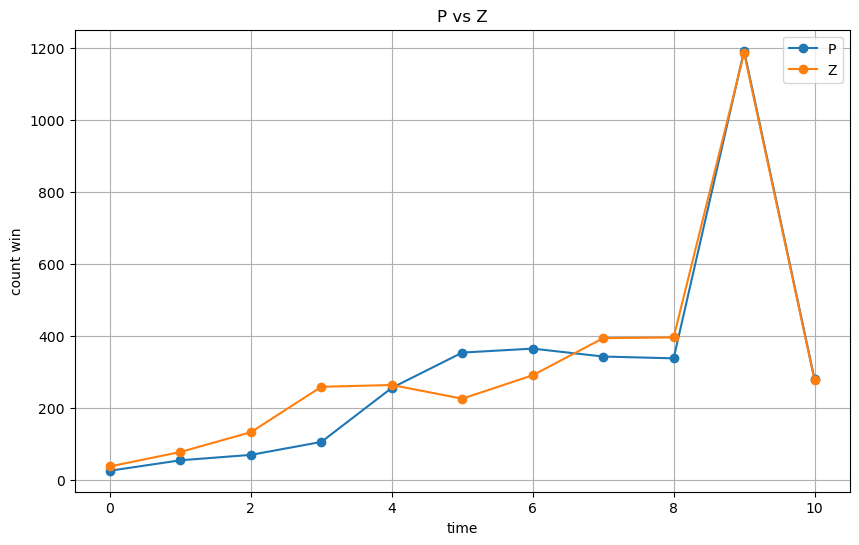

In [30]:
#P vs Z

time_wins_species_PZ = subset2[subset2['winner_species'] == 1].groupby('time')['winner_species'].count()
time_wins_species_ZP = subset2[subset2['winner_species'] == 2].groupby('time')['winner_species'].count()

result_PZ = pd.DataFrame({'Protoss_win': time_wins_species_PZ.values, 'Zerg_win': time_wins_species_ZP.values})
print(result_PZ)

plt.figure(figsize=(10, 6))
plt.plot(time_wins_species_PZ.index, time_wins_species_PZ.values, marker='o', linestyle='-', label='Winner Species 0')
plt.plot(time_wins_species_ZP.index, time_wins_species_ZP.values, marker='o', linestyle='-', label='Winner Species 1')
plt.xlabel('time')
plt.ylabel('count win')
plt.title('P vs Z')
plt.legend(['P','Z'])
plt.grid(True)

plt.show()

P vs Z전은 초반(0~4분)에는 Z가 더 높은 승률을 보이고 중반(4~6분)에는 P가, 그 이후는 비슷한양상을 보인다.

### 4) Event 분석

In [31]:
df.event.value_counts()

0    30283223
3    11060802
5     9615850
1     9112777
2     3633186
4      325751
6      142871
7       29617
Name: event, dtype: int64

Camera',Right Click,'GetControlGroup','Selection','SetControlGroup','AddToControlGroup', 'ControlGroup'순임.

-승리한 사람이 event가 더 많은가?

In [46]:
df_train['adjusted_event_diff'] = df_train.apply(lambda row: row['event_diff'] if row['winner'] == 0 else -row['event_diff'], axis=1)

total_adjusted_event_diff = df_train[df_train['adjusted_event_diff'] > 0]['event_diff'].count()
winner_positive_ratio= total_adjusted_event_diff/df_train['event_diff'].count()

print(f"승자가 패자보다 많은 event를 한 경기의 비율: {winner_positive_ratio:.2%}")

승자가 패자보다 많은 event를 한 경기의 비율: 54.17%


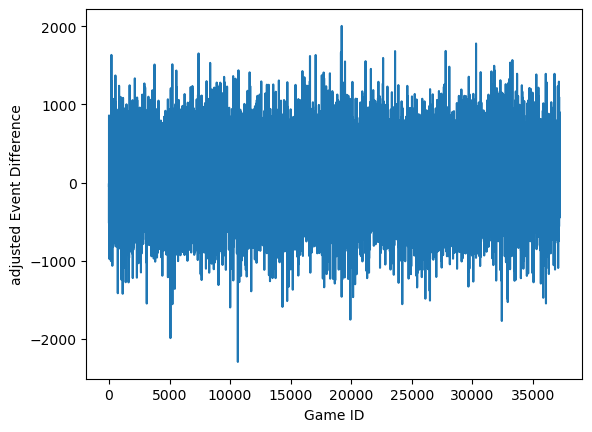

In [50]:
plt.plot(df_train['game_id'], df_train['adjusted_event_diff'])

plt.xlabel('Game ID')
plt.ylabel('adjusted Event Difference')
plt.show()

In [64]:
df_train[['winner','adjusted_event_diff']].corr()

,winner,adjusted_event_diff
winner,1.000000,-0.006948
adjusted_event_diff,-0.006948,1.000000


In [65]:
df_train[df_train['time'] == 3]

,game_id,winner,time,player0_species,player1_species,event_count_0,event_count_1,Camera_count_0,Camera_count_1,Selection_count_0,...,Selection_diff,Ability_diff,Right Click_diff,SetControlGroup_diff,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff,event_diff,winner_species,adjusted_event_diff
9,9,1,3,1,2,552,374,171.0,246.0,139.0,...,88.0,-1.0,72.0,2.0,94.0,-2.0,0.0,178,2.0,-178.0
15,15,0,3,0,0,373,524,81.0,338.0,64.0,...,20.0,3.0,-59.0,4.0,136.0,2.0,0.0,-151,0.0,-151.0
26,26,0,3,0,2,370,402,313.0,280.0,25.0,...,-40.0,-3.0,7.0,-13.0,-16.0,0.0,0.0,-32,0.0,-32.0
27,27,1,3,1,1,409,196,110.0,95.0,60.0,...,32.0,4.0,107.0,3.0,52.0,0.0,0.0,213,1.0,-213.0
33,33,0,3,2,2,496,526,105.0,78.0,88.0,...,-4.0,-1.0,67.0,6.0,-122.0,-3.0,0.0,-30,2.0,-30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37118,37118,0,3,2,1,401,388,79.0,200.0,141.0,...,59.0,-4.0,17.0,0.0,61.0,1.0,0.0,13,2.0,13.0
37133,37133,1,3,1,2,291,643,189.0,286.0,12.0,...,-37.0,0.0,26.0,1.0,-246.0,1.0,0.0,-352,2.0,352.0
37139,37139,1,3,0,1,737,251,632.0,131.0,49.0,...,0.0,0.0,-18.0,5.0,0.0,-2.0,0.0,486,1.0,-486.0
37154,37154,1,3,1,0,628,291,174.0,225.0,59.0,...,35.0,16.0,148.0,2.0,187.0,0.0,0.0,337,0.0,-337.0


## 변수 간 관계

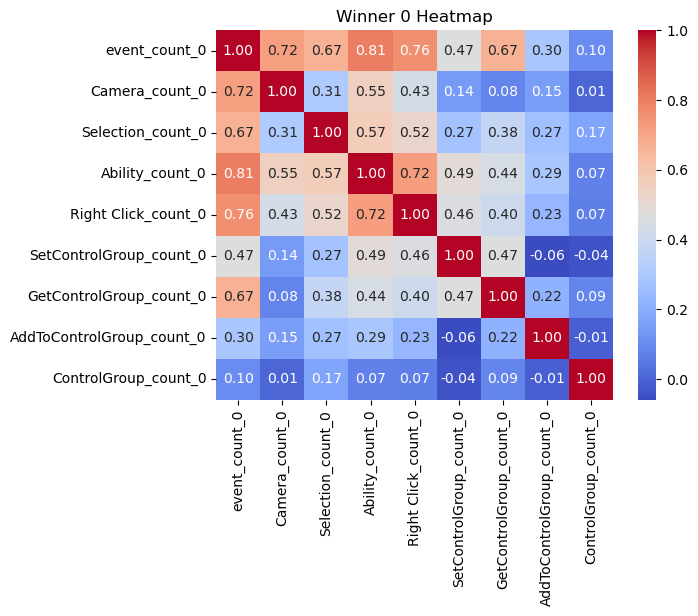

In [70]:
df_winner_0 = df_train[df_train['winner'] == 0]
df_winner_1 = df_train[df_train['winner'] == 1]

count_0_columns =  [col for col in df_train.columns if 'count_0' in col]
count_1_columns =  [col for col in df_train.columns if 'count_1' in col]
df_winner_0_selected = df_winner_0[count_0_columns]
df_winner_1_selected = df_winner_1[count_1_columns]

sns.heatmap(df_winner_0_selected.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Winner 0 Heatmap')
plt.show()

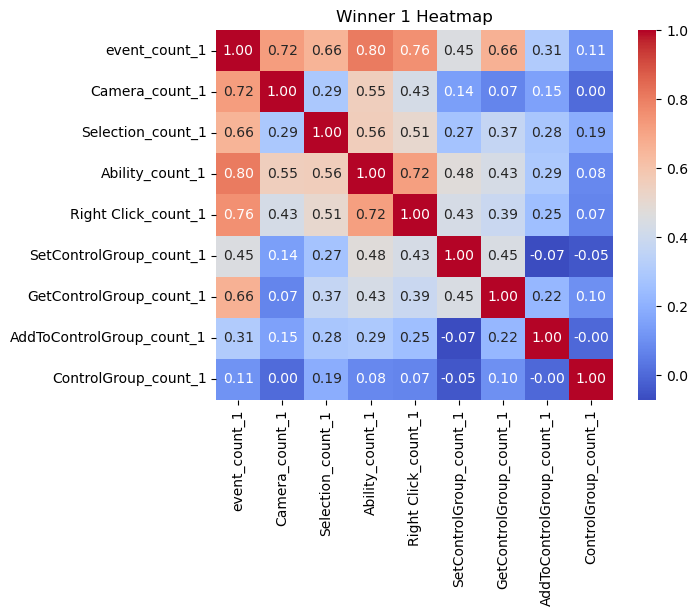

In [71]:
sns.heatmap(df_winner_1_selected.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Winner 1 Heatmap')
plt.show()

# 특정 게임 분석 (game_id = 16)

T vs P 전, T 승리, 9분 게임

In [57]:
df_six=df[df['game_id']==16]

In [58]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df_six

,game_id,winner,time,player,species,event,event_contents
27829,16,0,0,0,0,0,"at (145.25, 21.53515625)"
27830,16,0,0,1,1,0,"at (22.75, 147.0078125)"
27831,16,0,0,1,1,1,['Nexus [33C0001]']
27832,16,0,0,1,1,2,(15E0) - TrainProbe
27833,16,0,0,1,1,3,"Target: None [01680001]; Location: (18.0, 149...."
27834,16,0,0,1,1,3,"Target: None [02840001]; Location: (17.0, 148...."
27835,16,0,0,1,1,2,(15E0) - TrainProbe
27836,16,0,0,0,0,2,(1360) - TrainSCV
27837,16,0,0,1,1,3,"Target: None [00A80001]; Location: (18.0, 147...."
27838,16,0,0,1,1,3,"Target: None [00A80001]; Location: (18.0, 147...."


In [59]:
#카메라 빼고 보기
df_six[df_six['event'] != 2]

,game_id,winner,time,player,species,event,event_contents
27829,16,0,0,0,0,0,"at (145.25, 21.53515625)"
27830,16,0,0,1,1,0,"at (22.75, 147.0078125)"
27831,16,0,0,1,1,1,['Nexus [33C0001]']
27833,16,0,0,1,1,3,"Target: None [01680001]; Location: (18.0, 149...."
27834,16,0,0,1,1,3,"Target: None [02840001]; Location: (17.0, 148...."
27837,16,0,0,1,1,3,"Target: None [00A80001]; Location: (18.0, 147...."
27838,16,0,0,1,1,3,"Target: None [00A80001]; Location: (18.0, 147...."
27839,16,0,0,1,1,3,"Target: None [00A80001]; Location: (18.0, 147...."
27840,16,0,0,1,1,3,"Target: None [00A80001]; Location: (18.0, 147...."
27841,16,0,0,1,1,3,"Target: None [00A80001]; Location: (18.0, 147...."


In [60]:
df_six1=df_train[df_train['game_id'] == 16]

In [61]:
df_six1

,game_id,winner,time,player0_species,player1_species,event_count_0,event_count_1,Camera_count_0,Camera_count_1,Selection_count_0,Selection_count_1,Ability_count_0,Ability_count_1,Right Click_count_0,Right Click_count_1,SetControlGroup_count_0,SetControlGroup_count_1,GetControlGroup_count_0,GetControlGroup_count_1,AddToControlGroup_count_0,AddToControlGroup_count_1,ControlGroup_count_0,ControlGroup_count_1,Camera_diff,Selection_diff,Ability_diff,Right Click_diff,SetControlGroup_diff,GetControlGroup_diff,AddToControlGroup_diff,ControlGroup_diff,event_diff,winner_species
16,16,0,9,0,1,1155,1236,855.0,523.0,85.0,91.0,42.0,64.0,159.0,409.0,0.0,1.0,8.0,138.0,6.0,10.0,0.0,0.0,332.0,-6.0,-22.0,-250.0,-1.0,-130.0,-4.0,0.0,-81,0.0


In [62]:
temp = [0, 0.3, 1, 1.3, 2, 2.3, 3, 3.3, 4, 4.3,
       5, 5.3, 6, 6.3, 7, 7.3, 8, 8.3, 9, 9.3,10]
for i in range(0,20):
    df_six.loc[(df_six['time']>=temp[i])]

In [63]:
df_six['player'].value_counts()

1    1236
0    1155
Name: player, dtype: int64

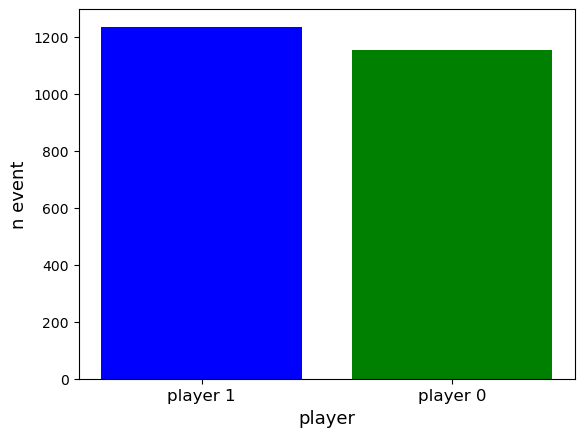

In [64]:
label = ['player 1', 'player 0']
index = np.arange(len(label))  
plt.bar(index, df_six['player'].value_counts(), color=('blue','green'))
plt.xlabel('player', fontsize=13)
plt.ylabel('n event', fontsize=13)
plt.xticks(index, label, fontsize=12)
plt.show()

<Axes: xlabel='event'>

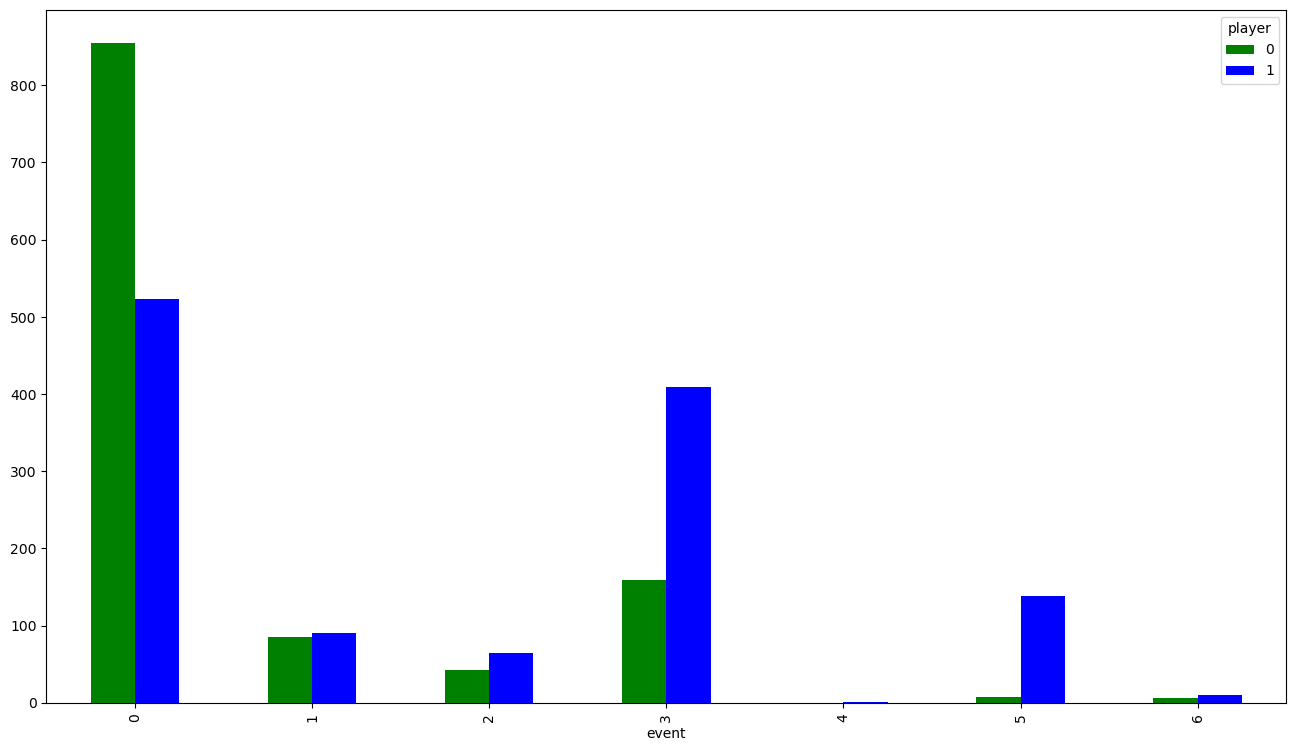

In [65]:
#Python
fig, ax = plt.subplots(figsize=(16,9))
df_six.groupby(['event','player']).count()['winner'].unstack().plot(ax=ax, color=('green','blue'),kind='bar')

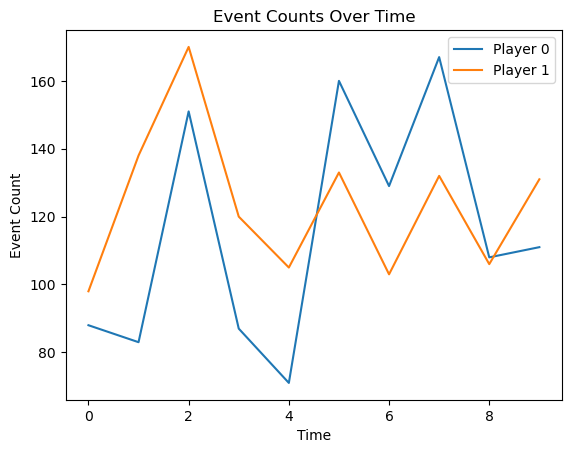

In [66]:
player0_events = df_six[df_six['player'] == 0].groupby('time').size()
player1_events = df_six[df_six['player'] == 1].groupby('time').size()

plt.plot(player0_events.index, player0_events.values, label='Player 0')
plt.plot(player1_events.index, player1_events.values, label='Player 1')

plt.title('Event Counts Over Time')
plt.xlabel('Time')
plt.ylabel('Event Count')
plt.legend()


plt.show()

In [67]:
#5분전까지는 1이 더 많고 5분 이후에는 player0가 많음.

In [68]:
df_six_play0=df_six[df_six['player'] == 0].groupby(['time', 'event']).size().unstack(fill_value=0)
df_six_play0

event,0,1,2,3,5,6
time,,,,,,
0,61,5,4,18,0,0
1,57,7,3,15,0,1
2,120,10,5,16,0,0
3,48,8,5,26,0,0
4,54,9,1,7,0,0
5,120,9,4,25,1,1
6,107,9,4,6,3,0
7,133,16,6,6,2,4
8,84,5,4,14,1,0


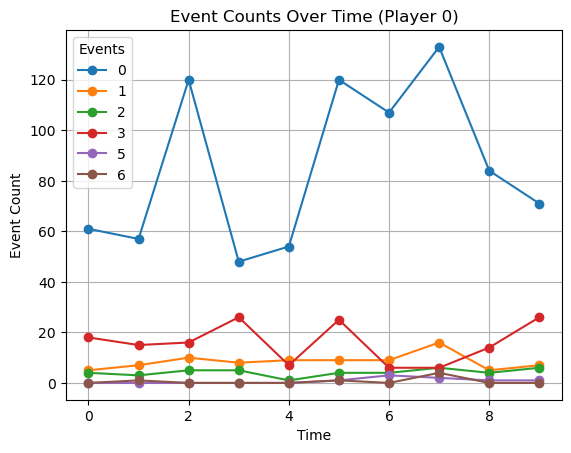

In [69]:
df_six_play0.plot(kind='line', marker='o')
plt.title('Event Counts Over Time (Player 0)')
plt.xlabel('Time')
plt.ylabel('Event Count')
plt.legend(title='Events')
plt.grid(True) 
plt.show()

In [70]:
df_six_play1=df_six[df_six['player'] == 1].groupby(['time', 'event']).size().unstack(fill_value=0)
df_six_play1

event,0,1,2,3,4,5,6
time,,,,,,,
0,18,3,5,69,0,2,1
1,24,9,6,56,0,42,1
2,54,9,3,61,0,43,0
3,68,11,4,26,0,11,0
4,62,5,8,26,0,1,3
5,59,8,7,31,0,25,3
6,49,14,11,23,0,5,1
7,81,8,8,32,1,2,0
8,51,9,3,36,0,6,1


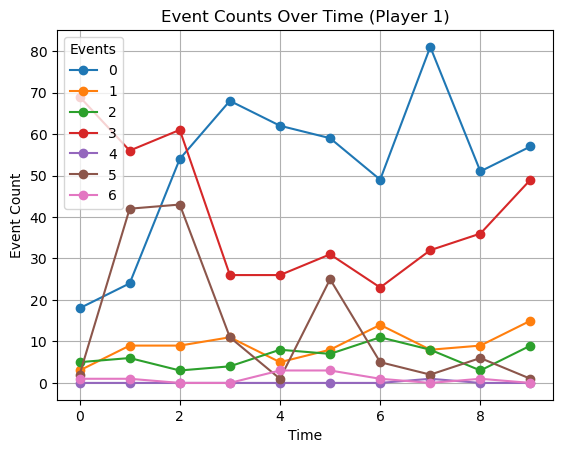

In [71]:
df_six_play1.plot(kind='line', marker='o')

plt.title('Event Counts Over Time (Player 1)')
plt.xlabel('Time')
plt.ylabel('Event Count')
plt.legend(title='Events')

plt.grid(True)  
plt.show()

player1: P, 게임에서짐.
0와 다르게 마우스 우클릭 횟수가 상당히 많고 점점 늘어감.
0,3,5번을 제외하면 흡사한 그림임.